In [1]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
import time
%matplotlib inline

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Sequential, model_from_json
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense ,Input
from keras.optimizers import Adam ,RMSprop

Using TensorFlow backend.


In [2]:
def load_dataset(path):
    data=load_files(path)
    plant_files=np.array(data['filenames'])
    plant_targets=np_utils.to_categorical(np.array(data['target']),12)
    return plant_files,plant_targets

print('Loading Train Files and Targets')
train_files, train_targets = load_dataset('/home/vishwasourab05/Plant Seedlings Classification/train')
print('Loading Complete!')
print('There are %d training plant images.' % len(train_files))



Loading Train Files and Targets
Loading Complete!
There are 4750 training plant images.


In [3]:
#list of plant names
plant_names= [item[58:-1] for item in sorted(glob("/home/vishwasourab05/Plant Seedlings Classification/train/*/"))]
print('There are %d total plant categories.' % len(plant_names))

There are 12 total plant categories.


In [4]:
plant_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [5]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (256, 256, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 256, 256, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255

100%|██████████| 4750/4750 [00:47<00:00, 99.33it/s] 


In [7]:
train_tensors.shape

(4750, 256, 256, 3)

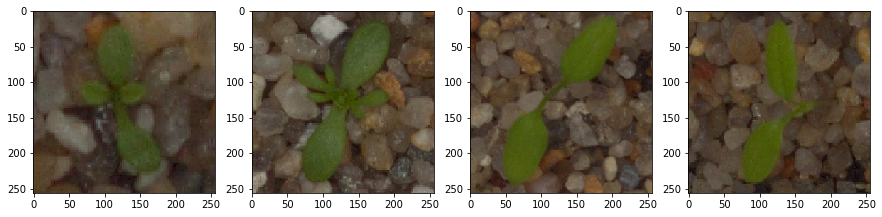

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(15,15))

axs[0].imshow(train_tensors[0])
axs[1].imshow(train_tensors[10])
axs[2].imshow(train_tensors[42])
axs[3].imshow(train_tensors[65])


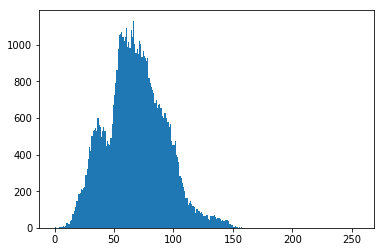

In [9]:
img = cv2.imread('train/Cleavers/005b4a3e3.png')
plt.hist(img.ravel(),256,[0,256]); plt.show()

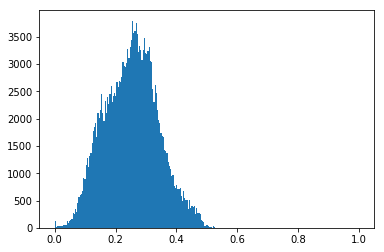

In [10]:
plt.hist(train_tensors[0].ravel(),256,[0,1])
plt.show()

In [11]:
# do not change seed to reproduce my results
seed = 31
np.random.seed(seed)



# Split the train and the validation set
train_tensors, val_train, train_targets, val_targets = train_test_split(train_tensors,
                                              train_targets, 
                                              test_size=0.15,
                                              random_state=seed
                                             )

print(train_tensors.shape)
print(val_train.shape)
print(train_targets.shape)
print(val_targets.shape)

(4037, 256, 256, 3)
(713, 256, 256, 3)
(4037, 12)
(713, 12)


In [12]:
model= Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
__________

In [13]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [14]:

checkpointer = ModelCheckpoint(filepath='saved_models/cnn_model_wo_aug_af.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, epochs = 20, validation_data = (val_train,val_targets),callbacks=[checkpointer],batch_size = 64)


Train on 4037 samples, validate on 713 samples
Epoch 1/20
4037/4037 [==============================] - 497s 123ms/step - loss: 2.4559 - acc: 0.1268 - val_loss: 2.4487 - val_acc: 0.1360

Epoch 00001: val_loss improved from inf to 2.44872, saving model to saved_models/cnn_model_wo_aug_af.hdf5
Epoch 2/20
4037/4037 [==============================] - 492s 122ms/step - loss: 2.3729 - acc: 0.1855 - val_loss: 2.1254 - val_acc: 0.2581

Epoch 00002: val_loss improved from 2.44872 to 2.12538, saving model to saved_models/cnn_model_wo_aug_af.hdf5
Epoch 3/20
4037/4037 [==============================] - 481s 119ms/step - loss: 2.1391 - acc: 0.2566 - val_loss: 2.1777 - val_acc: 0.1921

Epoch 00003: val_loss did not improve from 2.12538
Epoch 4/20
4037/4037 [==============================] - 478s 118ms/step - loss: 2.0454 - acc: 0.2725 - val_loss: 2.1937 - val_acc: 0.2202

Epoch 00004: val_loss did not improve from 2.12538
Epoch 5/20
4037/4037 [==============================] - 474s 118ms/step - loss:

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_tensors)

In [17]:
batch = 32

checkpointer = ModelCheckpoint(filepath='saved_models/cnn_model_with_aug_af.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit_generator(datagen.flow(train_tensors,train_targets,batch_size=batch),epochs = 30, validation_data = (val_train,val_targets),
                              verbose = 1, steps_per_epoch=train_tensors.shape[0] // batch
                              , callbacks=[learning_rate_reduction, checkpointer])

Epoch 1/30
126/126 [==============================] - 464s 4s/step - loss: 1.0065 - acc: 0.6753 - val_loss: 0.7959 - val_acc: 0.7055

Epoch 00001: val_loss improved from inf to 0.79587, saving model to saved_models/cnn_model_with_aug_af.hdf5
Epoch 2/30
126/126 [==============================] - 464s 4s/step - loss: 0.8596 - acc: 0.7031 - val_loss: 0.7347 - val_acc: 0.7447

Epoch 00002: val_loss improved from 0.79587 to 0.73474, saving model to saved_models/cnn_model_with_aug_af.hdf5
Epoch 3/30
126/126 [==============================] - 462s 4s/step - loss: 0.8089 - acc: 0.7286 - val_loss: 0.5254 - val_acc: 0.8247

Epoch 00003: val_loss improved from 0.73474 to 0.52545, saving model to saved_models/cnn_model_with_aug_af.hdf5
Epoch 4/30
126/126 [==============================] - 463s 4s/step - loss: 0.7990 - acc: 0.7428 - val_loss: 0.5892 - val_acc: 0.7658

Epoch 00004: val_loss did not improve from 0.52545
Epoch 5/30
126/126 [==============================] - 461s 4s/step - loss: 0.7116

In [18]:
model.load_weights('saved_models/cnn_model_with_aug_af.hdf5')
accuracy=model.evaluate(x=val_train,y=val_targets,batch_size=32)
print("Loss of the model: {} , Accuracy of Model :{} ".format(accuracy[0],accuracy[1]))

713/713 [==============================] - 27s 38ms/step
Loss of the model: 0.20048837616600795 , Accuracy of Model :0.9368863956791154 


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


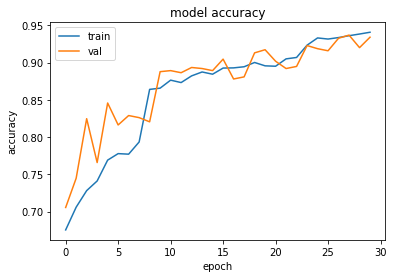

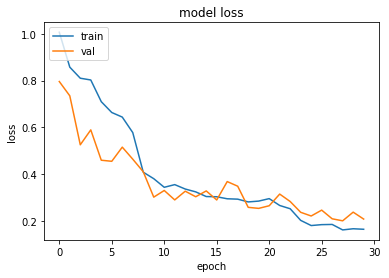

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
def one_hot_to_dense(labels_one_hot):
    num_labels = labels_one_hot.shape[0]
    num_classes = labels_one_hot.shape[1]
    labels_dense = np.where(labels_one_hot == 1)[1]      
    return labels_dense

In [21]:
validation_predictions = model.predict_classes(val_train)
report=classification_report(one_hot_to_dense(val_targets),validation_predictions)
print(report)

             precision    recall  f1-score   support

          0       0.69      0.65      0.67        34
          1       0.88      0.98      0.93        58
          2       0.98      0.86      0.91        50
          3       0.99      0.98      0.98        97
          4       0.94      0.94      0.94        36
          5       1.00      0.94      0.97        69
          6       0.87      0.88      0.88        94
          7       0.93      1.00      0.96        27
          8       0.93      0.99      0.96        72
          9       0.98      0.96      0.97        47
         10       0.99      1.00      0.99        76
         11       0.96      0.94      0.95        53

avg / total       0.94      0.94      0.94       713



In [22]:
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
           'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': species, 'abbreviation': abbreviation})

,abbreviation,class
0,BG,Black-grass
1,Ch,Charlock
2,Cl,Cleavers
3,CC,Common Chickweed
4,CW,Common wheat
5,FH,Fat Hen
6,LSB,Loose Silky-bent
7,M,Maize
8,SM,Scentless Mayweed
9,SP,Shepherds Purse


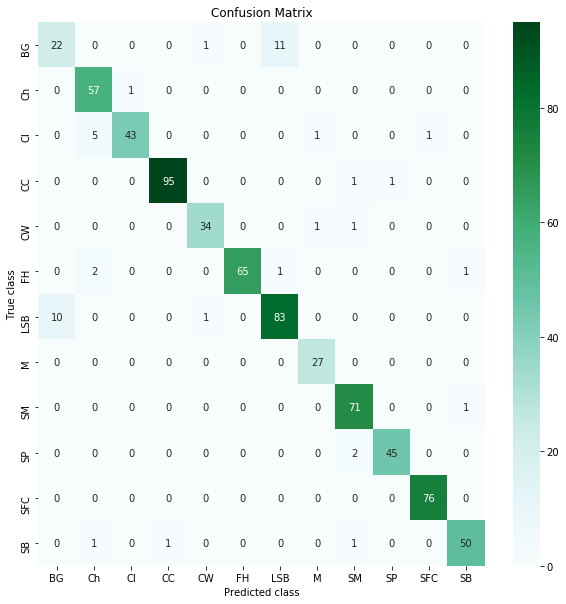

In [23]:
conf_mat= confusion_matrix(one_hot_to_dense(val_targets), validation_predictions)
fig, ax = plt.subplots(1,figsize=(10,10))

ax = sns.heatmap(conf_mat, ax=ax, cmap=plt.cm.BuGn, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [24]:
model_json = model.to_json()
with open("saved_models/model_after_rev.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("saved_models/model_after_rev.h5")
print("Saved model to disk")

Saved model to disk


In [25]:
def plant_seed_classification(image):
    
    image = path_to_tensor(image).astype('float32')/255
    
    json_file = open('saved_models/model_after_rev.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("saved_models/model_after_rev.h5")
    print("Loaded model from disk")
    
    prediction = model.predict_classes(image)
    
    print('The predicted Class of the image is {}'.format(prediction))
    INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
     }
    print('The class of the plant is',[INV_CLASS[p] for p in prediction])

In [26]:
plant_seed_classification('maize.png')

Loaded model from disk
The predicted Class of the image is [7]
The class of the plant is ['Maize']
